<a href="https://colab.research.google.com/github/Nick-Azzarano/Machine-Learning-Practice/blob/main/Spring2025/Homeworks/HW8_Azzarano_Nick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nick Azzarano
<br/>
CSCI 335
<br/>
Anton Selitskiy
<br/>
March 31, 2025

In [2]:
#from google.colab import drive
#drive.mount("/content/gdrive")
import numpy as np
import pandas as pd
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

#Homework 8
In this homework, we will write Gradient Boosting class and apply it to the date from the insuarance company about hospitalization chance. After transformation, data are numpy arrays, not dataframes.

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/anton-selitskiy/RIT_ML/refs/heads/main/2023_fall/Hospital.csv')
data.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,Sex,DaysInHospital
0,0,3,0,30,M,-1
1,0,0,0,30,M,-1
2,1,0,0,80,F,1
3,0,0,1,20,F,1
4,0,1,0,60,F,-1


In [5]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [7]:
transform = ColumnTransformer([('OneHot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['Sex'])], remainder='passthrough')

In [8]:
X_train_transformed = transform.fit_transform(X_train)
X_val_transformed = transform.transform(X_val)
X_test_transformed = transform.transform(X_test)

#Gradient Boosting

$$
a_N(x) = b_0(x)+\sum_{n=1}^N \gamma_n b_n(x) = b_0(x) + \gamma_1 b_1(x) +\ldots + \gamma_N b_N(x)
$$
Prediction is
$$
\hat{y}=\operatorname{sign} a_N(x).
$$

After you built this sum, next model $b_{N+1}(x)$ is trained on
$$
s^{(i)} = -\eta\left.\frac{\partial L(y, z)}{\partial z}\right|_{z=a_N(x^{(i)})}.
$$

After that, $\gamma_{N+1}$ is chosen from the following condition:
$$
L(y, a_N(x)+\gamma_{N+1}b_{N+1}(x)) \to \underset{\gamma_{N+1}}{\min}.
$$

##Q1 (12 pt). Implement boosting for binary classification.

Since gradient boosting is trained by sequentially creating models, it may happen that the model that is optimal in terms of generalization is obtained at an intermediate iteration. Usually, to control this behavior, a validation dataset is also passed to the `fit` method, which allows you to assess the overall model quality during training. In addition, it's not usefull to train a really deep model with 1000 or more trees if the optimal ensemble was achieved, for example, at the 70th iteration and did not improve for some number of iterations. Therefore, we will also use early stopping if there are no improvements over a certain number of iterations.

You will fill-in three things:

1 (4 pt). Function `_fit_new_model`

2 (4 pt). Early stopping in `fit`

3 (4 pt). Function `predict_proba` (Convert $a(x)$ into probability as in logistic regression).

In [21]:
class Boosting:

    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: dict={'max_features': 0.1},
        n_estimators: int=10,
        learning_rate: float=0.1,
        subsample: float=0.3,
        random_seed: int=228,
        custom_loss: list or tuple=None,
        use_best_model: bool=False,
        n_iter_early_stopping: int=None
    ):

        # Base model class
        self.base_model_class = base_model_class
        # Parameters for the base model
        self.base_model_params = base_model_params
        # Number of the base models
        self.n_estimators = n_estimators
        # Learnin rate (eta)
        self.learning_rate = learning_rate
        # Fraction of the training data for training of the individual model
        self.subsample = subsample
        # seed for bootstrap (if we want to reproduse the model, we could use it in base_model parameters)
        self.random_seed = random_seed
        # Use the number of models with the lowest validation loss
        self.use_best_model = use_best_model
        # The number of iterations without decreasing of the validation loss
        self.n_iter_early_stopping = n_iter_early_stopping

        # Placeholder for the first model prediction (a_0)
        self.initial_model_pred = None

        # Lis of the weights
        self.gammas = []

        # List of the base models
        self.models = [self.base_model_class(**self.base_model_params) for _ in range(self.n_estimators)]

        # Log-loss, if user's loss, then pass list: custom_loss = [loss, derivative]
        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()  #for two arrays returns a number
            self.loss_derivative = lambda y, z: (-y * self.sigmoid(-y * z)) #for two arrays returns an array

    def _fit_initial_model(self, X, y):
        """
        Function for the first model. It can be a constant, corresponding to the most popular class
        or any other model. We will use a constant.
        """

        idx = random.sample(range(X.shape[0]), int(self.subsample*X.shape[0]))
        X_s = X[idx,:]
        y_s = y[idx]

        c, c_counts = np.unique(y_s, return_counts=True)

        self.initial_model_pred = c[np.argmax(c_counts)]


    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, old_predictions: np.ndarray, n_model: int):
        """
        Function for an individual model of the boosting
        :param X: features
        :param y: target
        :param n_model: number of the current model
        """

        # Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:

        # Take the fraction self.subsample of the data (X, y, old_predictions):
        idx = random.sample(range(X.shape[0]), int(self.subsample*X.shape[0]))
        X_subset = X[idx,:]
        y_subset = y[idx]
        old_predictions_subset = old_predictions[idx]

        # Compute pseudo-residuals s using negative self.loss_derivative of y and old_predictions:
        s = -self.loss_derivative(y_subset, old_predictions_subset)

        # Fit n-th base model self.models[n_model].fit on (X_subset, s):
        self.models[n_model].fit(X_subset, s)




    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list=(0.01, 1)):
        """
        Function determines the best  gamma (the coeffitient for the new model).
        :param y: target
        :param old_predictions: prediction from the sum of previous models
        :param new_predictions: prediction of the new model
        :param boudnaries: array-like object with left and right boundaries for gamma
        """
        # Define initial loss and gamma
        loss, optimal_gamma = self.loss_fn(y, old_predictions), 0
        # Gridsearch for gamma
        gammas = np.linspace(*boundaries, 100)
        for gamma in gammas:
            predictions = old_predictions + gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                optimal_gamma = gamma
                loss = gamma_loss

        return optimal_gamma


    def fit(self, X, y, eval_set=None):
        """
        Function of the training the boosting model
        :param X: features (n_elments, n_features)
        :param y: target (n_elements, )
        :eval_set: tuple (X_val, y_val) or None
        """

        early_stop = np.zeros(self.n_iter_early_stopping)
        self._fit_initial_model(X,y)
        old_predictions = self.initial_model_pred*np.ones(len(y)) #.predict(X)
        self.loss = []
        self.loss_eval = []
        if eval_set != None:
            predictions_eval = self.initial_model_pred*np.ones(len(eval_set[1])) #.predict(eval_set[0])
        for i in range(self.n_estimators):
            # fit new model
            self._fit_new_model(X,y,old_predictions,i)
            # prediction of the i-th model
            new_predictions = self.models[i].predict(X)
            # calculate new gamma
            opt_gamma = self._find_optimal_gamma(y,old_predictions,new_predictions)
            self.gammas.append(opt_gamma)
            # update a(x)
            old_predictions = old_predictions + opt_gamma*new_predictions
            # calculate loss
            self.loss.append(self.loss_fn(y, old_predictions))
            # in case of evaluation set
            if eval_set != None:
                predictions_eval = predictions_eval + self.gammas[i]*self.models[i].predict(eval_set[0])
                self.loss_eval.append(self.loss_fn(eval_set[1], predictions_eval))
                print('iteration #', i, 'test_loss:', self.loss_eval[i], '  train_loss:', self.loss[i])

                # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

                # Update array early_stop with new validation loss value from the right
                # and check if all the values are close to the current self.loss_eval[i]
                # e.g., if np.linalg.norm(early_stop - self.loss_eval[i]) < 0.001: break
                early_stop[:-1] = early_stop[1:]  # Shift the array to the left
                early_stop[-1] = self.loss_eval[i]  # Add the current validation loss to the end
                if np.linalg.norm(early_stop - self.loss_eval[i]) < 0.001:  # Check if losses are close
                    print(f"Early stop at iteration {i}")
                    break
            else:
                print('train_loss:', self.loss[i])
        if (eval_set != None) and self.use_best_model:
             self.gammas = self.gammas[:np.argmin(self.loss_eval)+1]




    def predict(self, X: np.ndarray):
        """
        Function that predicts the classes
        :param X: feature matrix
        """

        pred = self.initial_model_pred*np.ones(len(X)) #.predict(X)
        for i in range(len(self.gammas)):
          pred = pred+self.gammas[i]*self.models[i].predict(X)
        return np.sign(pred)

    def predict_proba(self, X: np.ndarray):
        """
        Function predicts probabilities of class +1
        :param X: feature matrix
        """
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

        # Start with the initial model prediction
        pred = self.initial_model_pred * np.ones(len(X))

        # Add contributions from all base models
        for i in range(len(self.gammas)):
            pred += self.gammas[i] * self.models[i].predict(X)

        # Apply the sigmoid function to convert predictions to probabilities
        probabilities = self.sigmoid(pred)
        return probabilities




    @property
    def feature_importances_(self):
        """
        Extra credits (+3 pt)
        Function calculates feature importance.
        And it should be an attribute of the class
        """
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        # Calculate feature importance
        feature_importances = np.zeros(X_train_transformed.shape[1])
        for i in range(len(self.gammas)):
            feature_importances += self.gammas[i] * self.models[i].feature_importances_

The following cell will run your class. It should take about 10 seconds

In [26]:
%%time

boosting = Boosting(n_estimators = 1000, n_iter_early_stopping = 6, use_best_model=True)
boosting.fit(X_train_transformed, y_train, [X_val_transformed, y_val])

iteration # 0 test_loss: 0.44418299501836395   train_loss: 0.42983563451914925
iteration # 1 test_loss: 0.42633860865032047   train_loss: 0.4073426691381572
iteration # 2 test_loss: 0.41433942580873434   train_loss: 0.39110637933170533
iteration # 3 test_loss: 0.40533740668791546   train_loss: 0.3794870760981688
iteration # 4 test_loss: 0.4003148560792478   train_loss: 0.37111116829971547
iteration # 5 test_loss: 0.39617669950081924   train_loss: 0.3642920191618915
iteration # 6 test_loss: 0.39433013955912055   train_loss: 0.3595469789944071
iteration # 7 test_loss: 0.392020806916663   train_loss: 0.35517730631862765
iteration # 8 test_loss: 0.38976567201503093   train_loss: 0.35165682371837464
iteration # 9 test_loss: 0.38845131183176707   train_loss: 0.34926895675484304
iteration # 10 test_loss: 0.3870690836512343   train_loss: 0.34686833844543147
iteration # 11 test_loss: 0.3865927737989869   train_loss: 0.34532003885152146
iteration # 12 test_loss: 0.38586732762393045   train_loss:

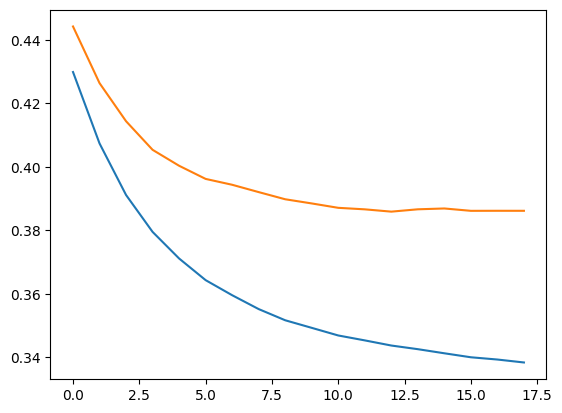

In [27]:
plt.plot(boosting.loss)
plt.plot(boosting.loss_eval)

## Q2 (4 pt). Use your trained Boosting classifier.
(a) Choose the threshold form (0, 1) to get recall $\approx 0.5$ on the validation set.

`recall_score((y_val+1)//2, boosting.predict_proba(X_val_transformed)>threshhold)`

(b) Plot Confusion Matrix for the Test based on this threshhold and calculate recall on Test.

(c) Plot ROC curve

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, RocCurveDisplay

In [29]:
# (a) Choose the threshold form (0, 1) to get recall  ≈0.5  on the validation set.
probs = boosting.predict_proba(X_val_transformed)

thresholds = np.linspace(0, 1, 100)
best_threshold = 0.5
best_recall = 0

for t in thresholds:
    recall = recall_score((y_val + 1) // 2, probs > t)
    if abs(recall - 0.5) < abs(best_recall - 0.5):
        best_threshold = t
        best_recall = recall

best_threshold, best_recall

(np.float64(0.26262626262626265), 0.5055487053020962)

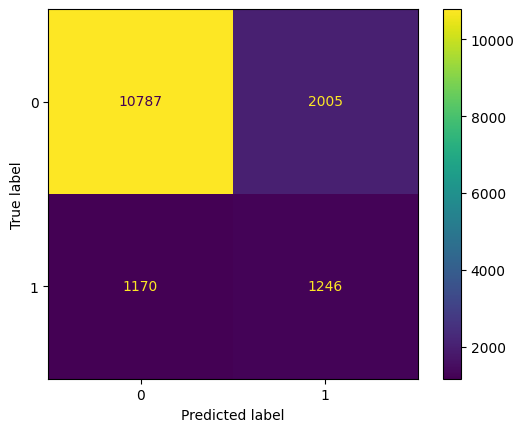

In [31]:
# (b) Plot Confusion Matrix for the Test based on this threshhold and calculate recall on Test.
probs_test = boosting.predict_proba(X_test_transformed)
y_pred_test = probs_test > best_threshold
ConfusionMatrixDisplay.from_predictions((y_test + 1) // 2, y_pred_test)
plt.show()

In [32]:
recall_test = recall_score((y_test + 1) // 2, y_pred_test)
recall_test

0.515728476821192

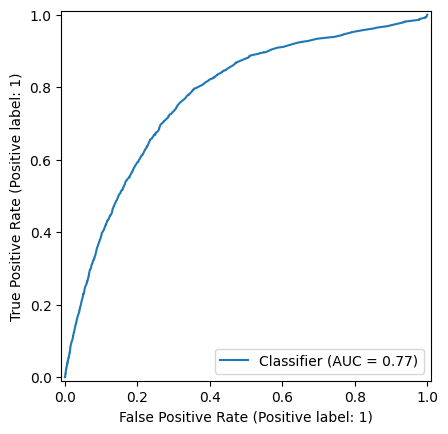

In [33]:
RocCurveDisplay.from_predictions((y_test + 1) // 2, probs_test)
plt.show()

## Q3 (4 pt). Train LightGBM Classifier on your data.
(a) Choose the threshold form (0, 1) to get recall $\approx 0.5$ on the validation set.

`recall_score((y_val+1)//2, gb.predict_proba(X_val_transformed)[:,1]>threshhold)`

(b) Plot Confusion Matrix for the Test based on this threshhold and calculate recall on Test.

(c) Plot ROC curve

`RocCurveDisplay.from_predictions(y_test, gb.predict_proba(X_test_transformed)[:,1])`

(d) Compare with the result of your model from Q2.

In [ ]:
import lightgbm as lgb

In [ ]:
gb = lgb.LGBMClassifier()

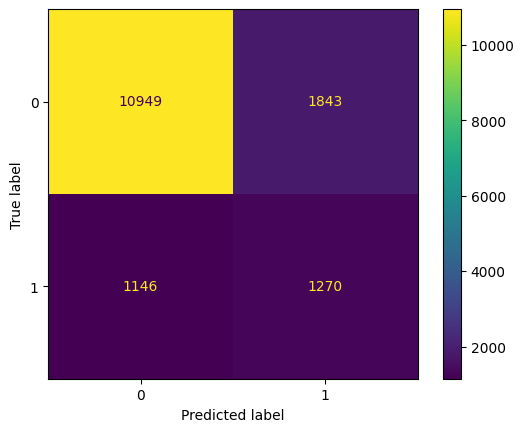

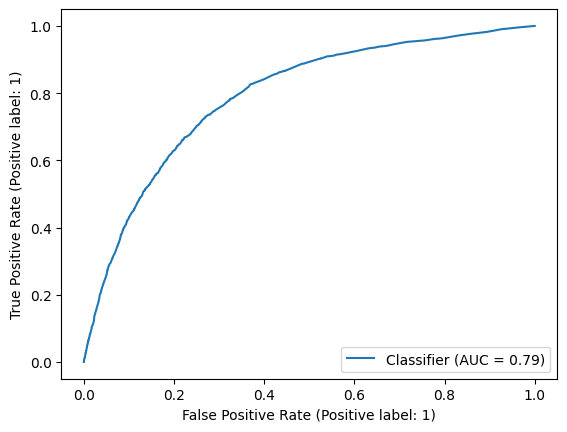

Are you satisfied with the result?